# Rolling Poisson regression
Modelling visit counts

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import pymc3 as pm

import theano
import theano.tensor as tt

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
np.random.seed(123)

## Generate data
Because we want to simulate counts, we constrain the values in the range $[0, \infty]$

In [4]:
variant_a_visits = np.random.normal(100, 20, 31).round().astype(int).clip(0)
variant_b_visits = np.random.normal(80, 30, 31).round().astype(int).clip(0)
days_of_the_month = list(np.arange(1, 32))

df = pd.DataFrame({'variant_a':variant_a_visits, 'variant_b':variant_b_visits, 'days_of_the_month':pd.Index(days_of_the_month)})

df.head()

,variant_a,variant_b,days_of_the_month
0,78,0,1
1,120,27,2
2,106,59,3
3,70,108,4
4,88,75,5


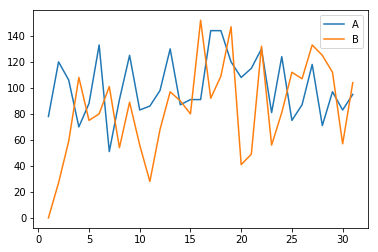

In [5]:
plt.plot(df.days_of_the_month, df.variant_a, label='A')
plt.plot(df.days_of_the_month, df.variant_b, label='B')
plt.legend()

pass

In [6]:
# Trasform the dataframe from short to long format (aka tidy format)
df = pd.melt(df, value_vars=['variant_a', 'variant_b'], id_vars='days_of_the_month', var_name='variant')
df['variant'] = df['variant'].astype('category')

df.head()

,days_of_the_month,variant,value
0,1,variant_a,78
1,2,variant_a,120
2,3,variant_a,106
3,4,variant_a,70
4,5,variant_a,88


## Modelling
Let's start with modelling only `variant_a`. Once we obtained a meaningful model for it we can move on and incorporate `variant_b` 


In [7]:
df_A = df.loc[df.variant=='variant_a', :]
df_A.variant.cat.remove_unused_categories(inplace=True)

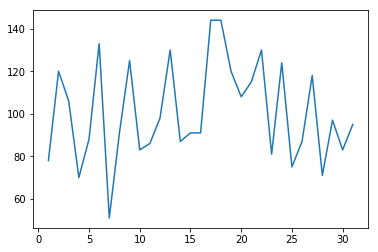

In [8]:
plt.plot(df_A.days_of_the_month, df_A.value);

We will be using a rolling regression. We want to infer the $\lambda$ of the Poisson regression for each day of the month. We assume the $\lambda$s are temporally correlated: $\lambda_t = \lambda_{t_1} + \mathcal{N}(0, \sigma)$. We can achieve this by using `GaussianRandomWalk`. See also https://docs.pymc.io/notebooks/GLM-rolling-regression.html

In [9]:
with pm.Model() as model:
    sigma_alpha = pm.Exponential('sigma_alpha', 1.5)
    
    alpha = pm.GaussianRandomWalk('alpha', init=pm.Normal.dist(mu=0, sd=50), sd=sigma_alpha, shape=df_A.shape[0])
    
    # link function to contraint the values to positive ones. 
    # In fact, the 'mu' of the Poisson distribution need to be positive.
    mu = pm.Deterministic('mu', tt.sqrt(tt.exp(alpha)))
    
    likelihood = pm.Poisson('likelihood', mu=mu, observed=df_A.value.values)
    
model.check_test_point()

sigma_alpha_log__       -1.06
alpha                   -9.24
likelihood          -11481.69
Name: Log-probability of test_point, dtype: float64

In [10]:
with model:
    trace = pm.sample(draws=1000, chains=2, cores=4, tune=1000, random_seed=123, nuts_kwargs={'target_accept':0.90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, sigma_alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:16<00:00, 240.43draws/s]


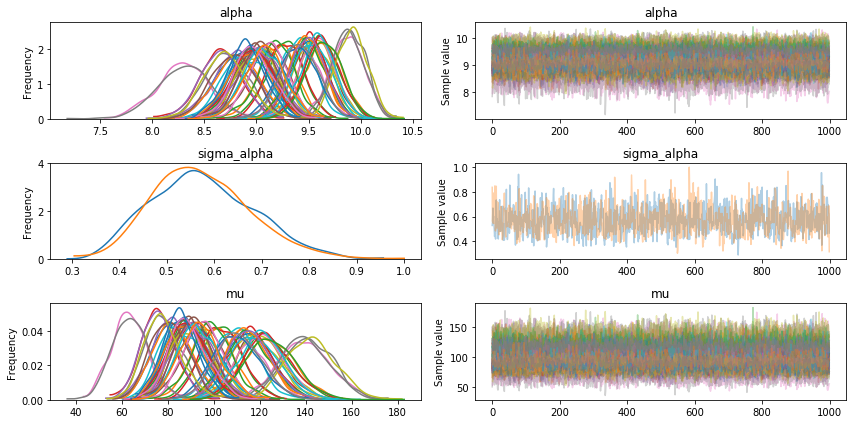

In [11]:
pm.traceplot(trace);

In [12]:
pm.summary(trace, varnames=['mu']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,82.30,8.75,0.14,65.01,98.74,3090.92,1.0
mu__1,114.57,9.88,0.21,95.33,134.44,2113.72,1.0
mu__2,103.43,9.00,0.19,85.17,120.42,2509.87,1.0
mu__3,76.02,7.57,0.17,61.85,91.58,2021.73,1.0
mu__4,89.79,8.83,0.15,74.01,107.87,3011.14,1.0
mu__5,120.63,9.99,0.20,101.79,140.58,2445.54,1.0
mu__6,63.68,7.89,0.17,47.71,78.60,1932.89,1.0
mu__7,90.16,8.61,0.17,74.23,107.22,2668.65,1.0
mu__8,117.74,10.15,0.21,99.17,138.46,2235.51,1.0
mu__9,87.19,8.19,0.16,72.75,104.17,2038.95,1.0


Check the model by generating posterior samples

In [13]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

100%|██████████| 1000/1000 [00:01<00:00, 856.20it/s]


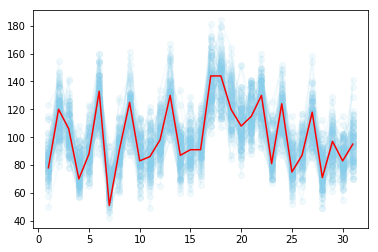

In [14]:
plt.plot(df_A.days_of_the_month, ppc['likelihood'][::10, :].T, color='skyblue', alpha=0.1, marker='o');
plt.plot(df_A.days_of_the_month, df_A.value, color='red')

pass